----

## 01 - Sampling
This notebook motivates the need to sample a signal appropriately to capture all of its information. We will begin by introducing the sampling process and explore sample rates used by different applications. Then we will investigate the effect of sampling a "continuous" waveform at different sampling frequencies and observe the effects of slow, fast, and reasonable sampling. Finally, the Nyquist sampling theorem will be introduced and the effects of aliasing discussed.

## Table of Contents
* [1. Introduction](#introduction)
* [2. Sampling - How Fast?](#sampling_how_fast)
* [3. Sampling Theorem](#sampling_theorem)
* [4. Aliasing](#aliasing)
* [5. Conclusion](#conclusion)

---

## 1. Introduction <a class="anchor" id="introduction"></a>
Sampling is traditionally performed by an analogue to digital converter (ADC) and can be thought of as recording the voltage level of an analogue signal at an instant in time. This sample is assigned a binary number through a process called quantisation - more on that later. By collecting samples at a regular period, we can approximate an analogue signal in a digital system. An illustration showing the discrete sampling process is presented in Figure 1.

<figure>
<img src="../img/Analogue_Digital_Signals.png" style="width: 80%;"/>
    <figcaption><b>Figure 1: The discrete sampling process.</b></figcaption>
</figure>

The time between samples is called the sampling period, $t_{s}$. The speed at which an ADC generates binary numbers is called the sampling rate or sampling frequency, $f_{s}$.

$$
f_{s} = 1 / t_{s}
$$

Sampling frequency is quoted in samples per second, or simply as Hertz (Hz). 

Let us begin by importing relevant Python libraries and modules for this notebook.

**When prompted, select the Radioconda Python environment**

In [3]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy.fftpack
import helper_functions as hf

This notebook is written for, and runs on, a digital system. Therefore, we cannot realistically generate a continuous analogue signal. However, for the purposes of this demonstration, we can approximate a continuous signal by creating a one using a high sampling rate.

In the following cell, we will create a "continuous" sine wave of frequency 100 Hz. The formula for generating a sine wave is

$$
y(t) = Asin(2\pi ft + \phi)
$$

where $\phi$ is the phase in radians, $f$ is the waveform's frequency, $t$ is the time, and $A$ is the waveform's amplitude.

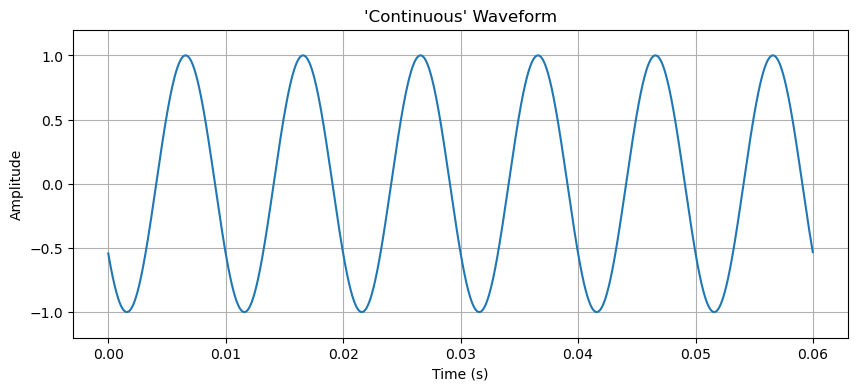

In [4]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

ar = 48000  # A high sample rate to approximate a continuous signal. ar = analogue rate

x_cont = np.arange(0, t, 1/ar)                    # Discrete time i.e. sampled time period
y_cont = A * np.sin(2 * np.pi * f * x_cont + p)   # Formula for sine wave

ax = hf.plot_timeseries("'Continuous' Waveform",
                        [x_cont], [y_cont],
                        ['continuous'])

## 2. Sampling - How Fast? <a class="anchor" id="sampling_how_fast"></a>

We must consider the required **sampling rate** to use so that we can retain **all** of the information in a signal.

Below, we will sample the "continuous" 100 Hz signal at various sampling rates and inspect the results.

Sampling at $f_{s}$=100 Hz, which is equivalent to 1 sample per period, gives the following waveform.

In [ ]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

fs = 100    # 100 Hz (1 sample per period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + p)    # Formula for sine wave

hf.plot_timeseries("Sampling Too Slow",
                   [x_cont, x], [y_cont, y], 
                   ['continuous', 'discrete'])